# Simulating optimized cell models in Arbor and cross-validation with Neuron

This notebook demonstrates how to run a simulation of a simple single compartmental cell with fixed/optimized parameters in Arbor. We follow the standard BluePyOpt flow of setting up an electrophysiological experiment and export the cell model to a mixed JSON/ACC-format. We then cross-validate voltage traces obtained with Arbor with those from a Neuron simulation.

In [1]:
# Choose subset of L5PC mechanisms to run (all regional mechs get re-mapped to soma)
mechanism_defs = dict(
    all=['pas'],
    somatic=['hh'])

extra_params = dict(
    v_init='global',
    # celsius='global',
    cm=['all'],
    Ra=['all'],
    g_pas=['all'],  # add 'pas' to mechs on all above
    e_pas=['all'],  # add 'pas' to mechs on all above
)

param_values_json = None

default_dt = 0.025

fine_dt = 0.001

voltage_residual_rel_l1_tolerance = 5e-2

run_spike_time_analysis = True

run_fine_dt = True

In [2]:
# Parameters
mechanism_defs = {"all": ["pas"], "axonal": ["CaDynamics_E2", "K_Pst", "Nap_Et2"]}
extra_params = {
    "v_init": "global",
    "celsius": "global",
    "g_pas": ["all"],
    "e_pas": ["all"],
    "cm": ["all"],
    "Ra": ["all"],
    "ena": ["axonal"],
    "ek": ["axonal"],
}
param_values_json = (
    "../../../BluePyOpt-utils/validation/all-regions-23-jan/param_values.json"
)
default_dt = 0.025
run_spike_time_analysis = False
run_fine_dt = True
voltage_residual_rel_l1_tolerance = 0.05


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload

First we need to compile the L5PC mechanisms and import the module that contains all the functionality to create electrical cell models

In [4]:
!nrnivmodl mechanisms
import bluepyopt as bpop
import bluepyopt.ephys as ephys

/root/venv/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set


/home/lukasd/src/arbor/dev/BluePyOpt/examples/l5pc


Mod files: "mechanisms/mechanisms/CaDynamics_E2.mod" "mechanisms/mechanisms/Ca_HVA.mod" "mechanisms/mechanisms/Ca_LVAst.mod" "mechanisms/mechanisms/Ih.mod" "mechanisms/mechanisms/Im.mod" "mechanisms/mechanisms/K_Pst.mod" "mechanisms/mechanisms/K_Tst.mod" "mechanisms/mechanisms/NaTa_t.mod" "mechanisms/mechanisms/NaTs2_t.mod" "mechanisms/mechanisms/Nap_Et2.mod" "mechanisms/mechanisms/SK_E2.mod" "mechanisms/mechanisms/SKv3_1.mod"



 -> Compiling mod_func.cpp


 => LINKING shared library ./libnrnmech.so


Successfully created x86_64/special


In [5]:
import os
import sys
import tempfile
from dataclasses import dataclass
import typing
import warnings
import multiprocessing

import numpy
import pandas
import scipy.integrate
import scipy.interpolate

import arbor

from IPython.display import display

If you want to see a lot of information about the internals, 
the verbose level can be set to 'debug' by commenting out
the following lines

In [6]:
# import logging
# logger = logging.getLogger()
# logger.setLevel(logging.DEBUG)

## Setting up the cell model

We use a single-compartimental cell model with the same morphology as in the `simplecell` example, but mechanisms from the `l5pc` model. They are instantiated with different options for axon replacement policy and (by default randomly sampled) mechanism parameter values.

In [7]:
# parameter randomization
import json
import random

# os.chdir('../../../BluePyOpt/examples/l5pc')
import l5pc_model

## Creating locations for Arbor

A protocol consists of a set of stimuli and recordings. These responses will later be used to compare voltage traces from simulations between Arbor and Neuron for different parameter values and axon replacement configurations.

For the protocols, we apply stimuli centrally at the soma and probe the membrane voltage at a slightly displaced location. For this purpose, we introduce locations in Arbor, which are specified by a relative position `pos` on a `branch` of the morphology.

In [8]:
# Define locations on branch 0 of the morphology (soma)
arb_locations = dict(
    stim_loc=ephys.locations.ArbBranchRelLocation(
        name='stim_loc',
        branch=0,
        pos=0.5
    ),
    probe_loc=ephys.locations.ArbBranchRelLocation(
        name='probe_loc',
        branch=0,
        pos=0.75
    )
)

In [9]:
nrn_locations = dict(
    stim_loc=ephys.locations.NrnSeclistCompLocation(
        name='soma',
        seclist_name='somatic',
        sec_index=0,
        comp_x=0.5),
    probe_loc=ephys.locations.NrnSeclistCompLocation(
        name='probe',
        seclist_name='somatic',
        sec_index=0,
        comp_x=0.75)
)

We use a modified version of the L5PC protocols with shortened stimulus duration and reduced amplitudes.

In [10]:
# Protocol prots configuration
protocol_steps = []
for name, amplitude, duration in [('bAP', 0.19, 5), ('Step1', 0.0458, 50), ('Step3', 0.095, 50)]:
    protocol_steps.append(
        dict(name=name,
             total_duration=120,
             stimuli=[
                 dict(name='%s.iclamp' % name,
                      location='stim_loc',
                      amplitude=amplitude,
                      delay=40,
                      duration=duration)],
             recordings=[
                 dict(name='%s.soma.v' % name,
                      location='probe_loc')]))

## Defining protocols to run with Arbor

To define a protocol in Arbor, we perform the same steps as for Neuron. That is we create stimuli and recordings and initialize an `ArbSweepProtocol` with it as a basic building block (analogous to `SweepProtocol` for Neuron). Note that we use location objects specific to Arbor, where the corresponding ones for Neuron are not well-defined on an Arbor morphology. The sweep protocol can then be assembled into other protocols as usual.

The protocols defined in the following are analogous to those of the L5PC model.

In [11]:
nrn_sweep_protocols = []
arb_sweep_protocols = []

for prot_def in protocol_steps:
    nrn_stims = []
    arb_stims = []
    for stim in prot_def['stimuli']:
        stim_args = dict(step_amplitude=stim['amplitude'],
                         step_delay=stim['delay'],
                         step_duration=stim['duration'],
                         total_duration=prot_def['total_duration'])

        nrn_stims.append(ephys.stimuli.NrnSquarePulse(location=nrn_locations[stim['location']],
                                                      **stim_args))

        arb_stims.append(ephys.stimuli.NrnSquarePulse(location=arb_locations[stim['location']],
                                                      **stim_args))

    nrn_recs = []
    arb_recs = []
    for rec in prot_def['recordings']:
        rec_args = dict(name=rec['name'],
                        variable='v')

        nrn_recs.append(ephys.recordings.CompRecording(location=nrn_locations[rec['location']],
                                                       **rec_args))

        arb_recs.append(ephys.recordings.CompRecording(location=arb_locations[rec['location']],
                                                       **rec_args))

    nrn_protocol = ephys.protocols.SweepProtocol(prot_def['name'], nrn_stims, nrn_recs)
    nrn_sweep_protocols.append(nrn_protocol)

    arb_protocol = ephys.protocols.ArbSweepProtocol(prot_def['name'], arb_stims, arb_recs)
    arb_sweep_protocols.append(arb_protocol)

nrn_protocol = ephys.protocols.SequenceProtocol('multistep', protocols=nrn_sweep_protocols)
arb_protocol = ephys.protocols.SequenceProtocol('multistep', protocols=arb_sweep_protocols)

## Mechanisms and parameters for cross-validation of Arbor and Neuron

To validate Arbor's simulation output with that of Neuron, we run the protocols over a set of parameter values, either loaded from a JSON-file or randomly sampled from the parameter bounds (using `random.uniform(*bounds)`) and both with and without axon replacement.

First, we gather L5PC mechanisms and parameters according to `mechanism_defs` and `extra_params` in the top cell of this notebook.

In [12]:
mechanisms = l5pc_model.create_mechanisms(
    dict(all=mechanism_defs['all'],
         somatic=[mech for loc, mechs in mechanism_defs.items() 
                  if loc != 'all' for mech in mechs]))

l5pc_param_configs = l5pc_model.load_parameters()
l5pc_param_names = []
for p in l5pc_param_configs:
    if 'mech' in p and p['mech'] in mechanism_defs.get(p['sectionlist'], []):
        l5pc_param_names.append(p['param_name'] + '.' + p['sectionlist'])

param_configs = []
for p in l5pc_param_configs:
    if 'mech' not in p:
        if p['param_name'] in extra_params and (p['type'] == 'global' or \
            p['sectionlist'] in extra_params[p['param_name']]):
            if p['type'] != 'global' and p['sectionlist'] != 'all':
                p['sectionlist'] = 'somatic'  # remap to soma
            param_configs.append(p)

    elif p['mech'] in mechanism_defs.get(p['sectionlist'], []):
        p['sectionlist'] = 'somatic'  # remap to soma
        param_configs.append(p)

if 'somatic' in mechanism_defs and 'hh' in mechanism_defs['somatic']:
    for param_name, bounds in [('gnabar', (0.05, 0.125)),
                               ('gkbar', (0.01, 0.075))]:
        param_configs.append({
            "param_name": param_name + "_hh",
            "mech": "hh",
            "bounds": bounds,
            "dist_type": "uniform",
            "type": "range",
            "sectionlist": "somatic"
        })

parameters = l5pc_model.create_parameters(param_configs)

# Print the names of all parameters
[p.name for p in parameters]

['g_pas.all',
 'e_pas.all',
 'cm.all',
 'Ra.all',
 'v_init',
 'celsius',
 'ena.somatic',
 'ek.somatic',
 'gNap_Et2bar_Nap_Et2.somatic',
 'gK_Pstbar_K_Pst.somatic',
 'gamma_CaDynamics_E2.somatic',
 'decay_CaDynamics_E2.somatic']

We either randomly sample or read the values of non-frozen parameters from a file.

In [13]:
if not hasattr(arbor.segment_tree, 'tag_roots'):  # skip axon replacement if not yet supported
    replace_axon = [False]
else:
    replace_axon = [False, True]

non_frozen_parameters = [param for param in parameters if not param.frozen]
param_names = [param.name for param in non_frozen_parameters]

if param_values_json is not None:
    with open(param_values_json) as f:
        params = []
        for param_sample in json.load(f):
            ps = dict()
            for p_name, p_value in param_sample.items():
                if p_name in l5pc_param_names:
                    ps[p_name.split('.')[0] + '.somatic'] = p_value
            params.append(ps)
else:
    params = [{param.name: random.uniform(*param.bounds)
               for param in non_frozen_parameters}
               for i in range(10)]
params

[{'gNap_Et2bar_Nap_Et2.somatic': 0.32323186939717896,
  'gK_Pstbar_K_Pst.somatic': 0.632350108686711,
  'gamma_CaDynamics_E2.somatic': 0.006732616529303067,
  'decay_CaDynamics_E2.somatic': 313.3415919671918},
 {'gNap_Et2bar_Nap_Et2.somatic': 1.9587356647399599,
  'gK_Pstbar_K_Pst.somatic': 0.2093902307357135,
  'gamma_CaDynamics_E2.somatic': 0.04746902048178322,
  'decay_CaDynamics_E2.somatic': 917.2352505126088},
 {'gNap_Et2bar_Nap_Et2.somatic': 3.8659417795378777,
  'gK_Pstbar_K_Pst.somatic': 0.5860562499756466,
  'gamma_CaDynamics_E2.somatic': 0.005330282127447699,
  'decay_CaDynamics_E2.somatic': 796.5192081393701},
 {'gNap_Et2bar_Nap_Et2.somatic': 3.720120748887276,
  'gK_Pstbar_K_Pst.somatic': 0.7024462358416235,
  'gamma_CaDynamics_E2.somatic': 0.018075268369690936,
  'decay_CaDynamics_E2.somatic': 285.32445556818533},
 {'gNap_Et2bar_Nap_Et2.somatic': 0.6204213584906646,
  'gK_Pstbar_K_Pst.somatic': 0.8955661205507032,
  'gamma_CaDynamics_E2.somatic': 0.04788353515818717,
  'de

## Running an Arbor protocol

The interface of an Arbor protocol is the same as that for Neuron with the only difference that an instance of `ArbSimulator` must be supplied to the `run` method. In addition, if axon-replacement is used, the morphology must be instantiated on the cell model.

Upon invoking the `protocol.run` method, the cell model is exported to a mixed JSON/ACC-format (cf. [generate_acc.py](generate_acc.py)) and an Arbor cable cell is assembled. Protocol stimuli and recordings are instantiated on this cell and an Arbor simulation is run.

To create cell models with different configurations for the cross-validation, we use a factory in the following. This enables us to run both Arbor and Neuron simulations for the defined sequence protocols and each combination of axon replacement and parameter values...

In [14]:
@dataclass
class CellModelFactory:
    mechanisms: typing.List[ephys.mechanisms.NrnMODMechanism]
    parameters: typing.List[ephys.parameters.NrnParameter]

    def create_cell_model(self, do_replace_axon):

        morphology = ephys.morphologies.NrnFileMorphology(
            '../simplecell/simple.swc', do_replace_axon=do_replace_axon)

        return ephys.models.CellModel(
            'simple_cell',
            morph=morphology,
            mechs=self.mechanisms,
            params=self.parameters)

@dataclass
class SimulationRunner:
    cell_factory: CellModelFactory
    arb_protocol: ephys.protocols.SequenceProtocol
    nrn_protocol: ephys.protocols.SequenceProtocol

    def run_all(self, replace_axon_policies, param_list, dt=0.025):
        arb_resp = dict()
        nrn_resp = dict()

        nrn_sim = ephys.simulators.NrnSimulator(dt=dt)
        arb_sim = ephys.simulators.ArbSimulator(dt=dt)

        for do_replace_axon in replace_axon_policies:
            for param_i in range(len(param_list)):

                cell_model = self.cell_factory.create_cell_model(do_replace_axon=do_replace_axon)

                # calculate morphology with axon-replacement in Neuron
                cell_model.instantiate_morphology_3d(nrn_sim)

                key = (do_replace_axon, param_i)
                arb_resp[key] = self.arb_protocol.run(cell_model, param_list[param_i], arb_sim)

                # need to destroy instantiated cell model first to avoid Hoc serialization error
                cell_model.destroy(sim=nrn_sim)

                nrn_resp[key] = self.nrn_protocol.run(cell_model, param_list[param_i], nrn_sim)
        return arb_resp, nrn_resp


cell_factory = CellModelFactory(mechanisms, parameters)
simulation_runner = SimulationRunner(cell_factory, arb_protocol, nrn_protocol)
arb_responses, nrn_responses = simulation_runner.run_all(replace_axon, params, default_dt)

...and to plot the responses for visual validation.

In [15]:
def plot_response_comparison(arb_resp, nrn_resp, title):
    num_protocols = len(protocol_steps)
    num_recs = max([len(step['recordings']) for step in protocol_steps])
    assert num_recs == 1  # add j as a second index with multiple recordings
    fig, ax = plt.subplots(num_protocols, num_recs, figsize=(12,7))
    for i, step in enumerate(protocol_steps):
        for j, rec in enumerate(step['recordings']):
            rec_name = rec['name']
            ax[i].plot(nrn_resp[rec_name]['time'], nrn_resp[rec_name]['voltage'], label='Neuron ' + rec_name)
            ax[i].plot(arb_resp[rec_name]['time'], arb_resp[rec_name]['voltage'], label='Arbor ' + rec_name)
            ax[i].set_title(title)
            ax[i].legend(loc='upper left')
    plt.tight_layout()
    plt.show()

### The cross-validation metric

To analyze the responses, we compare the difference of voltage traces between Arbor and Neuron in the L1-norm. 

In [16]:
def voltage_trace_residual_l1_norm(int_resp, ref_resp):
    int_resp_func = scipy.interpolate.interp1d(int_resp['time'], int_resp['voltage'], kind='cubic')
    ref_resp_func = scipy.interpolate.interp1d(ref_resp['time'], ref_resp['voltage'], kind='cubic')
    abs_diff = lambda t: abs(int_resp_func(t)-ref_resp_func(t))
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=scipy.integrate.IntegrationWarning)
        if isinstance(ref_resp, pandas.DataFrame):
            time_start, time_end = (ref_resp['time'].iloc[0], ref_resp['time'].iloc[-1])
        else:
            time_start, time_end = (ref_resp['time'][0], ref_resp['time'][-1])
        return scipy.integrate.quad(abs_diff, time_start, time_end, limit=400)


def voltage_trace_residual_l1_norm_sweep_protocol(args):
    arb_resp = args['arb_resp'].response
    nrn_resp = args['nrn_resp'].response

    residual_l1_norm, residual_error = voltage_trace_residual_l1_norm(
        nrn_resp, arb_resp)

    nrn_to_min_l1_norm, nrn_to_min_error = \
        voltage_trace_residual_l1_norm(
            nrn_resp,
            dict(time=nrn_resp['time'].values,
                 voltage=numpy.full(nrn_resp['voltage'].shape,
                                    numpy.min(nrn_resp['voltage']))))
    return dict(
        residual_rel_l1_norm=residual_l1_norm/nrn_to_min_l1_norm,
        residual_rel_l1_error=residual_error/residual_l1_norm + \
                            nrn_to_min_error/nrn_to_min_l1_norm
    )


def analyze_voltage_traces_l1(arb_resp, nrn_resp):
    indices = [(key,step) for key in arb_resp for step in arb_resp[key]]

    # test_l5pc: insert if True:
    with multiprocessing.Pool(multiprocessing.cpu_count()) as pool:
        l1_task_results = pool.map(voltage_trace_residual_l1_norm_sweep_protocol,
                                   [dict(arb_resp=arb_resp[key][step],
                                         nrn_resp=nrn_resp[key][step])
                                    for key, step in indices])

    l1_results = []
    for l1_task_result, (key, step) in zip(l1_task_results, indices):
            l1_results.append(
                dict(replace_axon=key[0],
                     param_i=key[1],
                     **params[key[1]],
                     protocol=step,
                     **l1_task_result))

    return pandas.DataFrame(l1_results)


l1_results = analyze_voltage_traces_l1(arb_responses, nrn_responses)
pandas.options.display.float_format = '{:,.3g}'.format
l1_results.sort_values(by='residual_rel_l1_norm', ascending=False).head(5)

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gK_Pstbar_K_Pst.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
7,False,2,3.87,0.586,0.00533,797,Step1.soma.v,0.0043,2.73e-07
8,False,2,3.87,0.586,0.00533,797,Step3.soma.v,0.00384,7.75e-07
9,False,3,3.72,0.702,0.0181,285,bAP.soma.v,0.00283,4.14e-07
24,True,3,3.72,0.702,0.0181,285,bAP.soma.v,0.00224,2.89e-08
6,False,2,3.87,0.586,0.00533,797,bAP.soma.v,0.00185,2.62e-07


In [17]:
def print_voltage_trace_l1_results(config_str, l1_results):
    voltage_residual_rel_l1_error_tolerance = 1e-2 * voltage_residual_rel_l1_tolerance

    mean_rel_l1_norm = l1_results['residual_rel_l1_norm'].mean()
    mean_rel_l1_error = l1_results['residual_rel_l1_error'].mean()
    # max_l1_norm_record = l1_results.loc[l1_results['residual_rel_l1_norm'].idxmax()]

    message = '{}: test_l5pc %s! The mean relative Arbor-Neuron L1-deviation and error (tol in brackets) are {:,.3g} ({:,.3g}), {:,.3g} ({:,.3g}).'.format(
        config_str, mean_rel_l1_norm, voltage_residual_rel_l1_tolerance, mean_rel_l1_error, voltage_residual_rel_l1_error_tolerance)
    if mean_rel_l1_norm < voltage_residual_rel_l1_tolerance and mean_rel_l1_error < voltage_residual_rel_l1_error_tolerance:
        print(message % 'OK')
    else:
        print(message % 'ERROR')


print_voltage_trace_l1_results('Default dt ({:,.3g})'.format(default_dt), l1_results)

Default dt (0.025): test_l5pc OK! The mean relative Arbor-Neuron L1-deviation and error (tol in brackets) are 0.000903 (0.05), 2.97e-05 (0.0005).


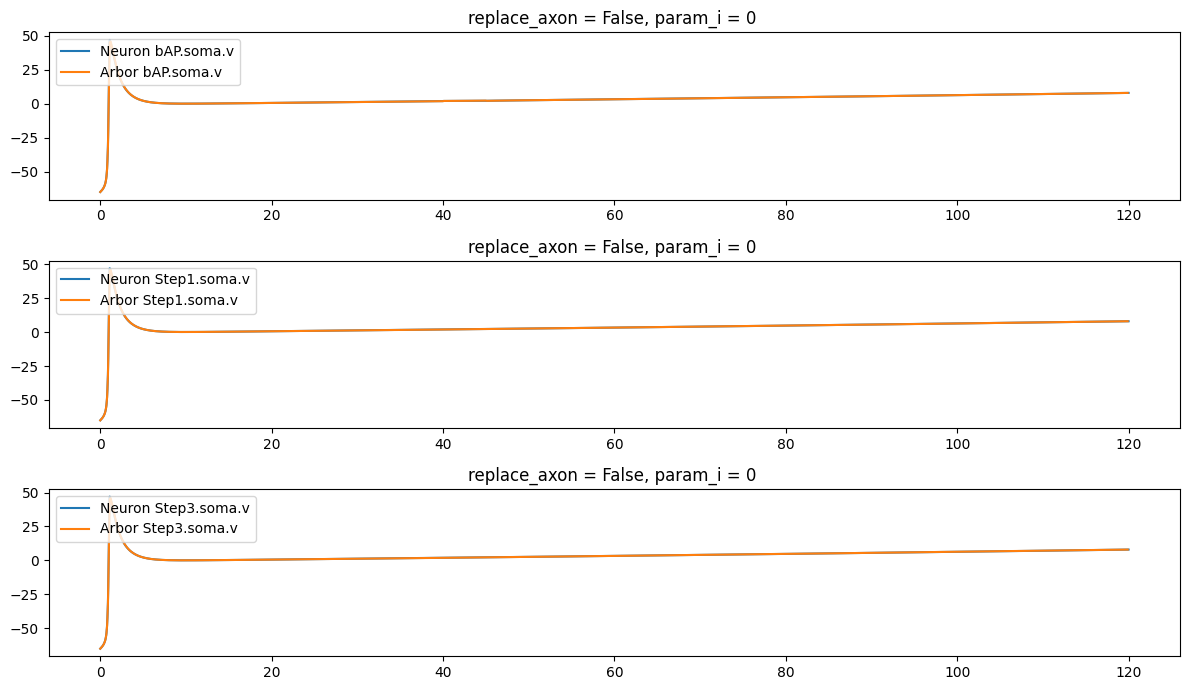

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gK_Pstbar_K_Pst.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
0,False,0,0.323,0.632,0.00673,313,bAP.soma.v,0.000337,0.000103
1,False,0,0.323,0.632,0.00673,313,Step1.soma.v,0.000381,1.49e-05
2,False,0,0.323,0.632,0.00673,313,Step3.soma.v,0.00036,6.31e-06


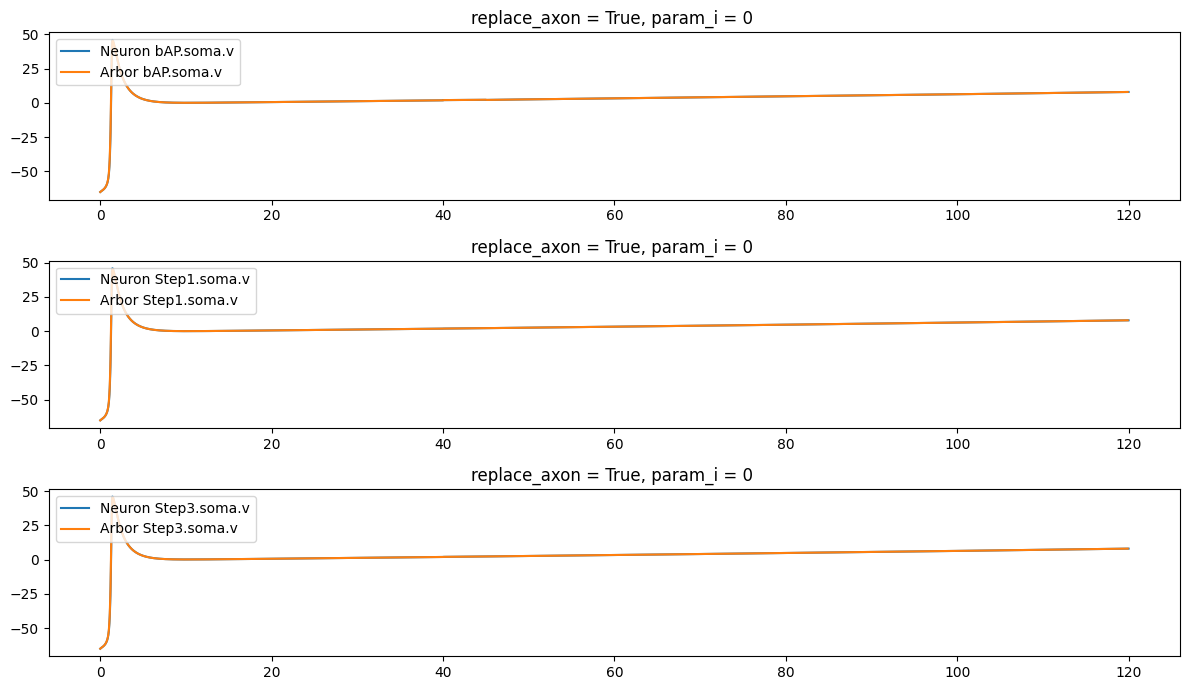

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gK_Pstbar_K_Pst.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
15,True,0,0.323,0.632,0.00673,313,bAP.soma.v,0.000211,6.83e-05
16,True,0,0.323,0.632,0.00673,313,Step1.soma.v,0.000202,0.000236
17,True,0,0.323,0.632,0.00673,313,Step3.soma.v,0.00022,7.05e-05


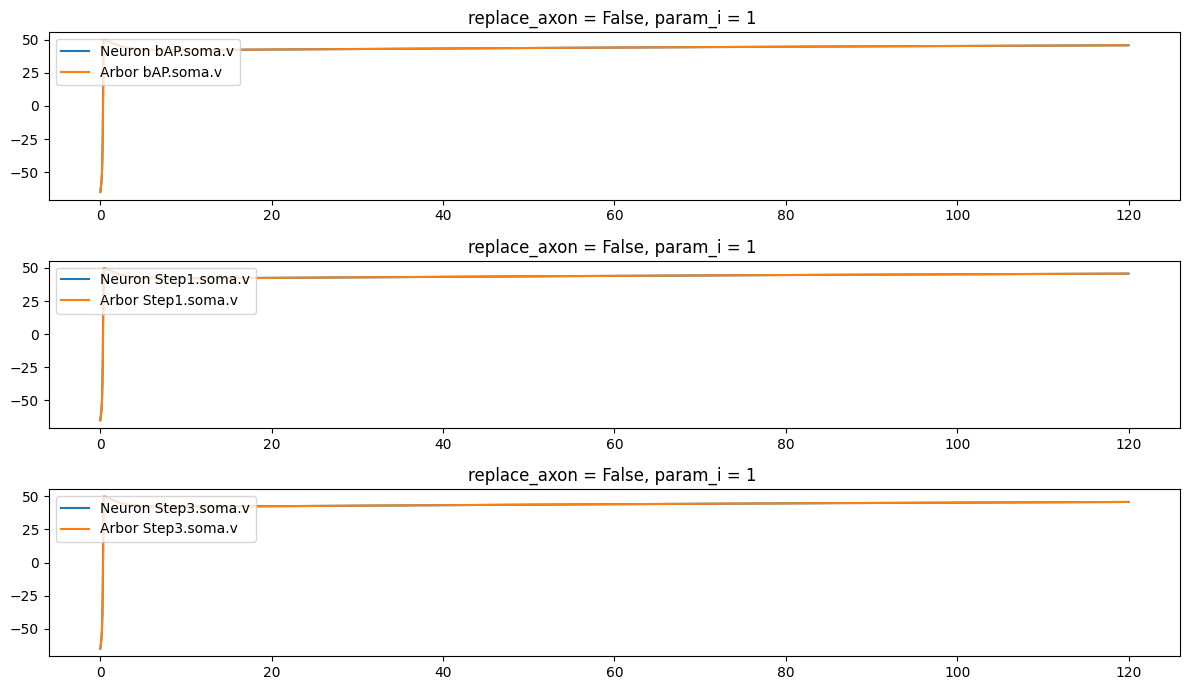

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gK_Pstbar_K_Pst.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
3,False,1,1.96,0.209,0.0475,917,bAP.soma.v,0.00165,4.99e-08
4,False,1,1.96,0.209,0.0475,917,Step1.soma.v,0.00139,1.32e-07
5,False,1,1.96,0.209,0.0475,917,Step3.soma.v,0.00155,1.4e-07


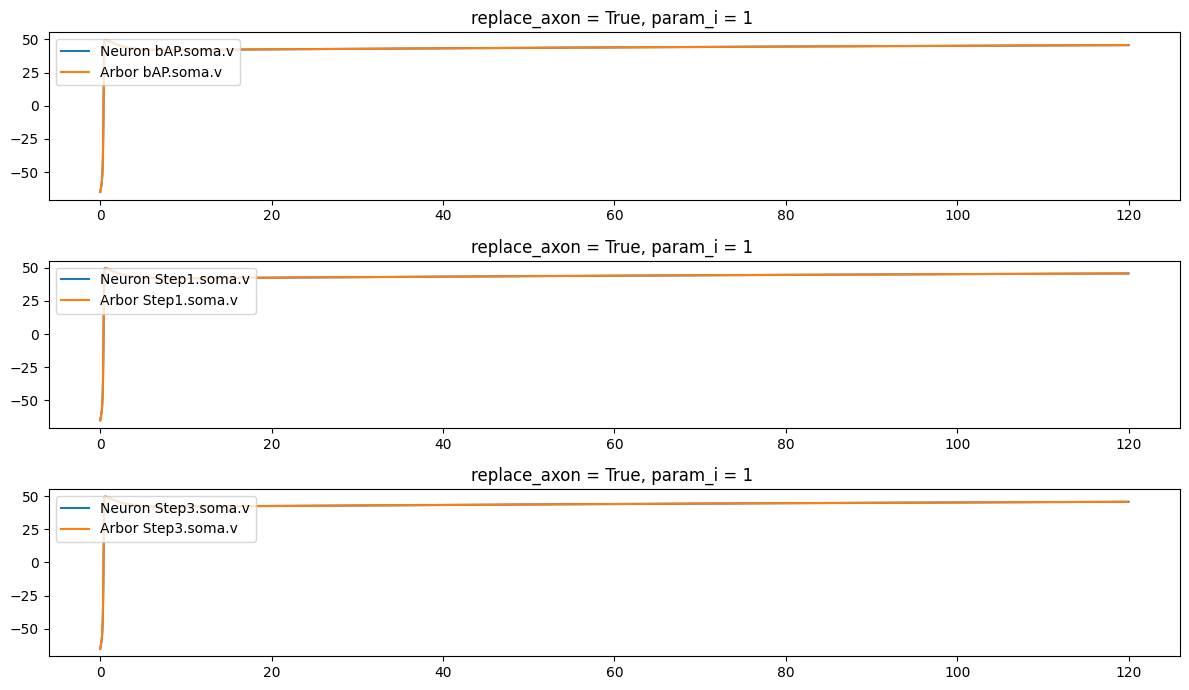

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gK_Pstbar_K_Pst.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
18,True,1,1.96,0.209,0.0475,917,bAP.soma.v,0.00164,1.18e-07
19,True,1,1.96,0.209,0.0475,917,Step1.soma.v,0.000187,6.8e-07
20,True,1,1.96,0.209,0.0475,917,Step3.soma.v,0.000188,2.72e-07


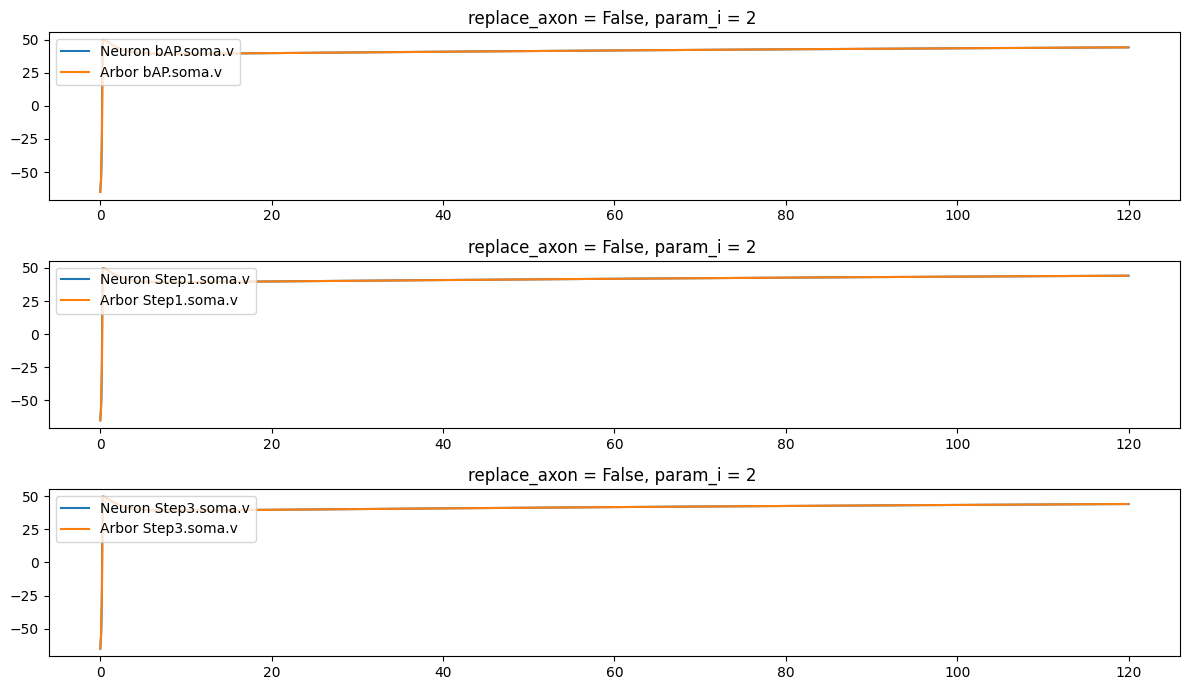

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gK_Pstbar_K_Pst.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
6,False,2,3.87,0.586,0.00533,797,bAP.soma.v,0.00185,2.62e-07
7,False,2,3.87,0.586,0.00533,797,Step1.soma.v,0.0043,2.73e-07
8,False,2,3.87,0.586,0.00533,797,Step3.soma.v,0.00384,7.75e-07


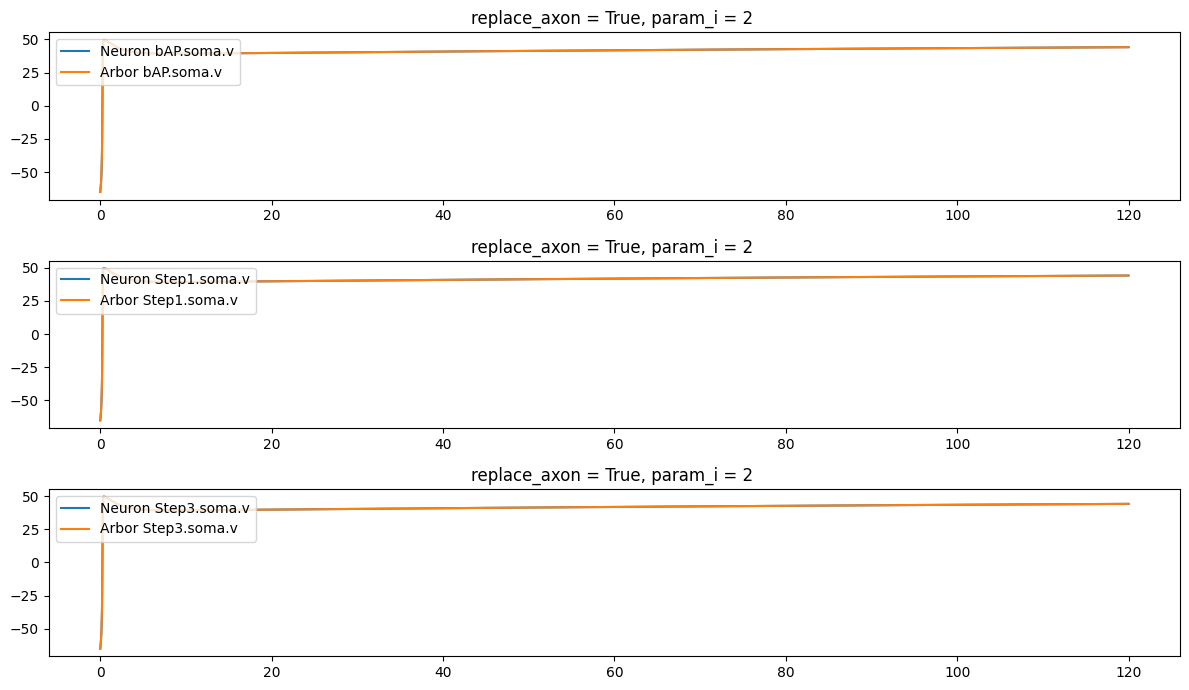

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gK_Pstbar_K_Pst.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
21,True,2,3.87,0.586,0.00533,797,bAP.soma.v,0.00013,2.59e-08
22,True,2,3.87,0.586,0.00533,797,Step1.soma.v,0.000146,2.49e-08
23,True,2,3.87,0.586,0.00533,797,Step3.soma.v,0.000152,6.64e-08


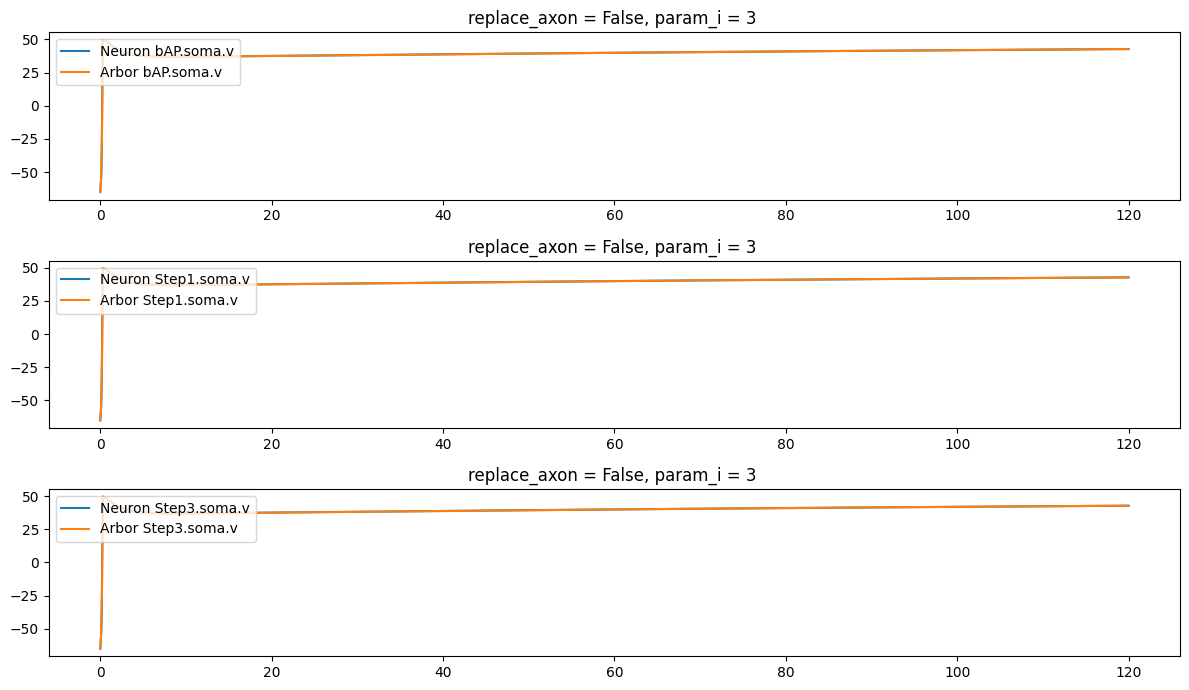

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gK_Pstbar_K_Pst.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
9,False,3,3.72,0.702,0.0181,285,bAP.soma.v,0.00283,4.14e-07
10,False,3,3.72,0.702,0.0181,285,Step1.soma.v,0.000279,3.46e-07
11,False,3,3.72,0.702,0.0181,285,Step3.soma.v,0.00101,6.37e-07


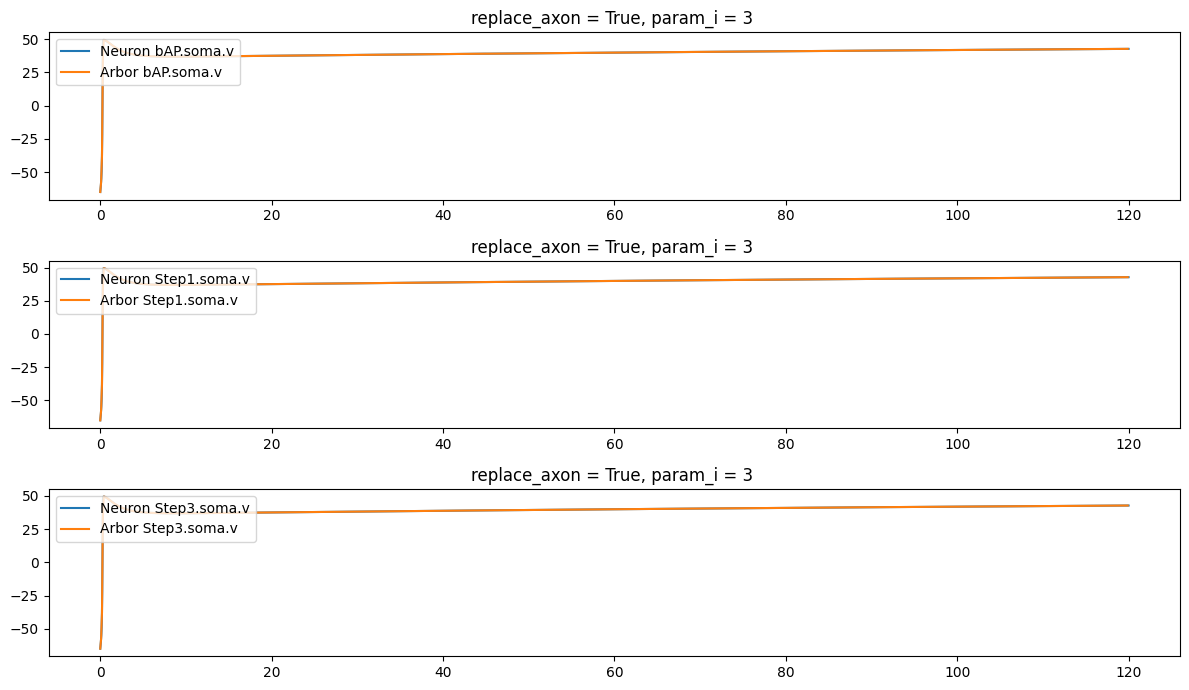

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gK_Pstbar_K_Pst.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
24,True,3,3.72,0.702,0.0181,285,bAP.soma.v,0.00224,2.89e-08
25,True,3,3.72,0.702,0.0181,285,Step1.soma.v,0.000208,1.07e-06
26,True,3,3.72,0.702,0.0181,285,Step3.soma.v,0.000178,1.16e-07


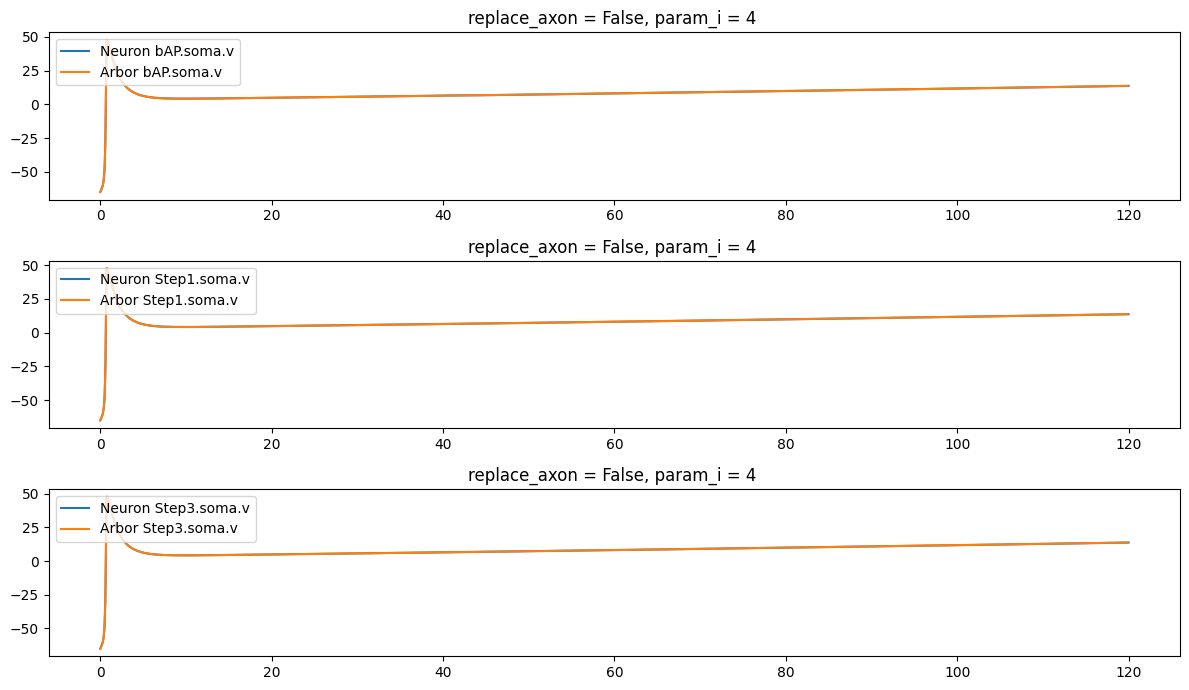

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gK_Pstbar_K_Pst.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
12,False,4,0.62,0.896,0.0479,681,bAP.soma.v,0.00035,1.97e-05
13,False,4,0.62,0.896,0.0479,681,Step1.soma.v,0.000342,0.00016
14,False,4,0.62,0.896,0.0479,681,Step3.soma.v,0.000339,0.000204


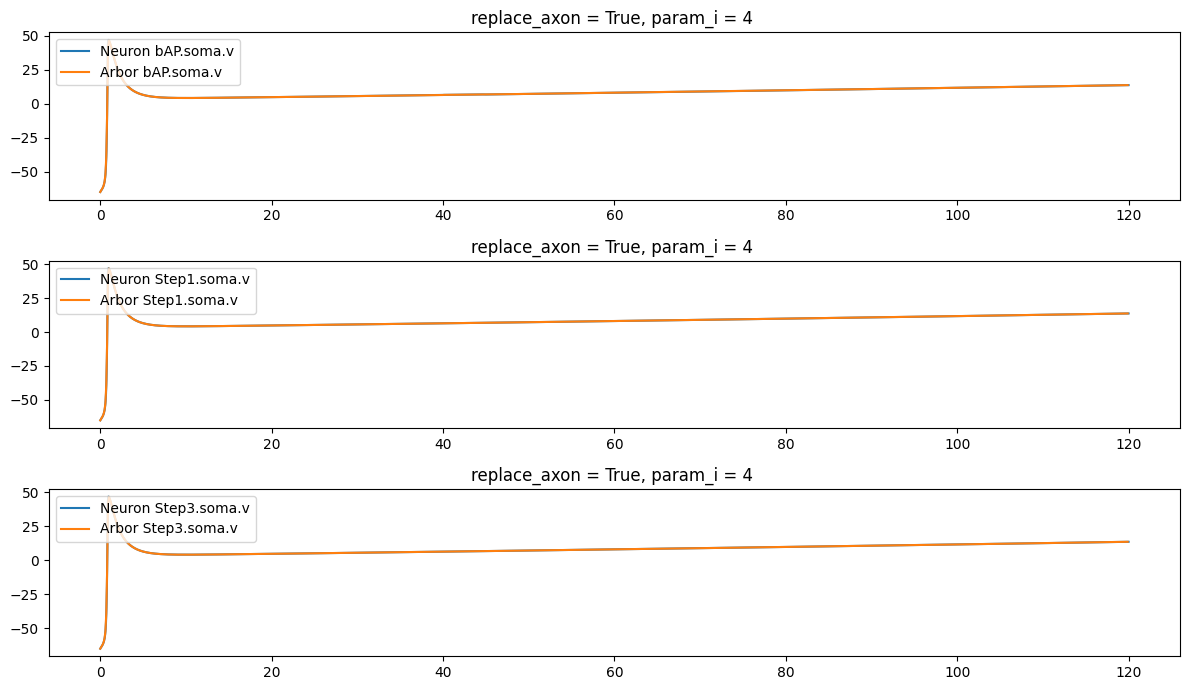

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gK_Pstbar_K_Pst.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
27,True,4,0.62,0.896,0.0479,681,bAP.soma.v,0.000194,1.5e-06
28,True,4,0.62,0.896,0.0479,681,Step1.soma.v,0.000203,1.73e-06
29,True,4,0.62,0.896,0.0479,681,Step3.soma.v,0.000187,1.16e-06


In [18]:
def compare_responses(arb_resp, nrn_resp, l1_results, *key):
    if key in arb_resp:
        plot_response_comparison(arb_resp[key], nrn_resp[key], 'replace_axon = %s, param_i = %s ' % (key[0], key[1]))
        display(l1_results[(l1_results['replace_axon'] == key[0]) & (l1_results['param_i'] == key[1])])


for param_i in range(len(params)):  # test_l5pc: skip
    for do_replace_axon in replace_axon:  # test_l5pc: skip
        compare_responses(arb_responses, nrn_responses, l1_results, do_replace_axon, param_i)  # test_l5pc: skip

The voltage traces look mostly similar between Arbor and Neuron. Under certain conditions, we can perform spike time analysis to understand this quantitatively. 

### Spike time cross-validation

To compare Arbor and Neuron voltage traces further, we analyze the spike counts and times with the eFEL library. Note that in contrast to eFEL that measures the `peak_time`, Arbor's built-in spike detector measures the time when the voltage surpasses a given voltage threshold.

In [19]:
if run_spike_time_analysis:

    efel_features = ['Spikecount',
                    'time_to_first_spike',
                    'time_to_second_spike',
                    'time_to_last_spike']


    # Extract spike observables from protocol simulation responses
    def get_spike_data(protocols, do_replace_axon, param_values,
                       arb_resp, nrn_resp):
        spike_res = []

        for step in protocols:
            recording_name = step['recordings'][0]['name'] # use only first recording
            stim_start = min([stim['delay'] for stim in step['stimuli']])
            stim_end = max([stim['delay'] + stim['duration'] for stim in step['stimuli']])

            for efel_feature_name in efel_features:
                # Calculate spike observables with eFEL
                feature_name = '%s.%s' % (step['name'], efel_feature_name)
                feature = ephys.efeatures.eFELFeature(
                            feature_name,
                            efel_feature_name=efel_feature_name,
                            recording_names={'': recording_name},
                            stim_start=stim_start,
                            stim_end=stim_end)

                spike_res.append(dict(
                    replace_axon=do_replace_axon,
                    protocol=step['name'],
                    **param_values,
                    efel=efel_feature_name,
                    Neuron=feature.calculate_feature(nrn_resp),
                    Arbor=feature.calculate_feature(arb_resp)))
        return spike_res


    # Compare spike observables between Arbor and Neuron
    def analyze_spikes(spike_res):
        spike_res_df = pandas.DataFrame(spike_res)
        spike_res_df.set_index(
            ['replace_axon', 'protocol',
             *param_names, 'efel'], inplace=True)
        spike_res_df.dropna(how='all', inplace=True)  # drop all-NaN rows

        # Arbor to Neuron cross-validation with eFEL
        spike_res_df['abs_diff Arbor to Neuron'] = \
            spike_res_df.apply(
                lambda r: abs(r['Arbor']-r['Neuron']), axis=1)
        spike_res_df['rel_abs_diff Arbor to Neuron [%]'] = \
            spike_res_df.apply(
                lambda r: 100.*abs(r['Arbor']-r['Neuron'])/r['Neuron']
                          if r['Neuron'] != 0 else numpy.nan, axis=1)

        return spike_res_df


    # Aggregate all simulations into a single data frame 
    def joint_spike_analysis(arb_resp, nrn_resp, replace_axon_policies, param_list):
        return pandas.concat(
            [analyze_spikes(get_spike_data(protocol_steps,
                                           replace_axon_policies[key[0]],
                                           param_list[key[1]],
                                           arb_resp[key],
                                           nrn_resp[key]))
             for key in arb_resp], axis=0)


    pandas.options.display.float_format = '{:,.3g}'.format
    # pandas.options.display.max_rows = None  # uncomment for full view
    spike_results = joint_spike_analysis(arb_responses, nrn_responses, replace_axon, params)
    display(spike_results)

To understand the deviations over the entire parameter set and different axon replacement policies, we explore the per eFEL-observable statistics. Compare the `Spikecount`s that are usually fully consistent between Arbor and Neuron, whereas `time_to_last_spike` are the least consistent of these variables.

In [20]:
if run_spike_time_analysis:
    display(spike_results[['abs_diff Arbor to Neuron',
                           'rel_abs_diff Arbor to Neuron [%]']].groupby('efel').describe())

We can inspect the traces with highest difference in `time_to_last_spike` to identify outliers.

In [21]:
if run_spike_time_analysis:
    display(spike_results[ [el[spike_results.index.names.index('efel')] == 'time_to_last_spike'
                            for el in spike_results.index] ].sort_values(
                            by='abs_diff Arbor to Neuron', ascending=False).head(5))

## Running protocols with a finer time step

To rule out the discretization as a possible source of the above error in `time_to_last_spike`, we can re-run the simulations at a smaller `dt` of 0.001 ms (default is 0.025 ms).

In [22]:
if run_fine_dt:
    arb_responses_fine_dt, nrn_responses_fine_dt = simulation_runner.run_all(replace_axon, params, dt=fine_dt)

    l1_results_fine_dt = analyze_voltage_traces_l1(arb_responses_fine_dt, nrn_responses_fine_dt)

    display(l1_results_fine_dt.sort_values(by='residual_rel_l1_norm', ascending=False).head(5))

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gK_Pstbar_K_Pst.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
7,False,2,3.87,0.586,0.00533,797,Step1.soma.v,0.00426,0.000825
8,False,2,3.87,0.586,0.00533,797,Step3.soma.v,0.0038,5.94e-05
9,False,3,3.72,0.702,0.0181,285,bAP.soma.v,0.00277,1.03e-06
24,True,3,3.72,0.702,0.0181,285,bAP.soma.v,0.0023,4.29e-08
6,False,2,3.87,0.586,0.00533,797,bAP.soma.v,0.00181,4.4e-06


In [23]:
if run_fine_dt:
    print_voltage_trace_l1_results('Fine dt ({:,.3g})'.format(fine_dt), l1_results_fine_dt)

Fine dt (0.001): test_l5pc OK! The mean relative Arbor-Neuron L1-deviation and error (tol in brackets) are 0.000893 (0.05), 0.000178 (0.0005).


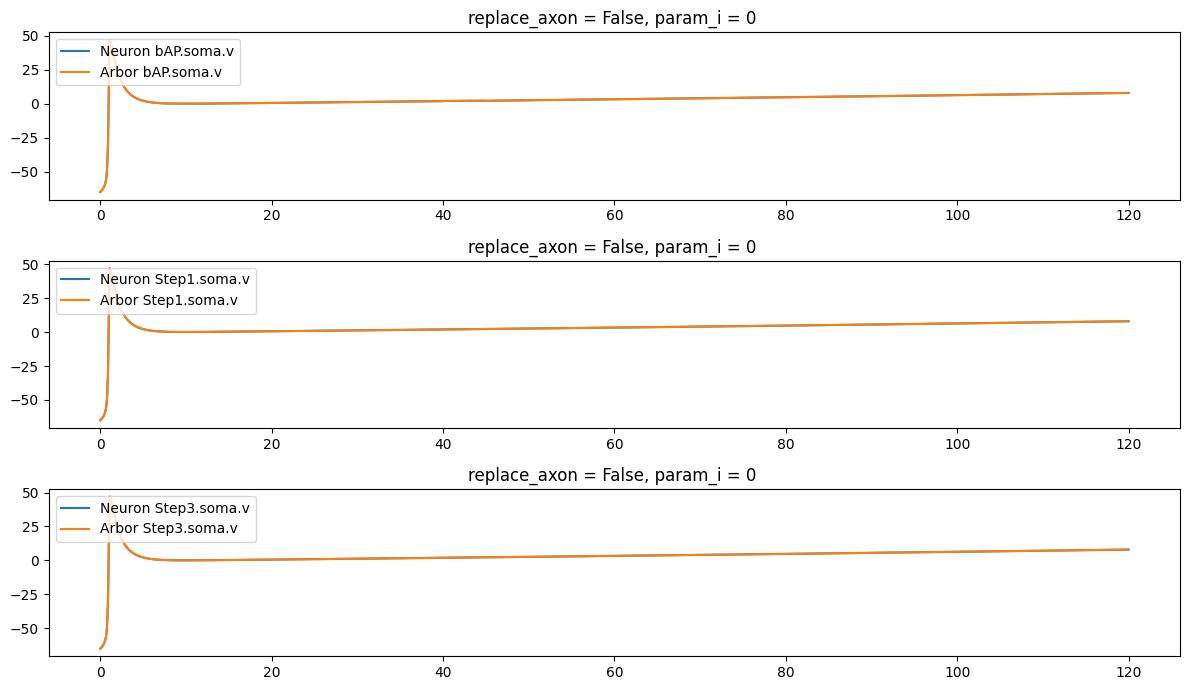

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gK_Pstbar_K_Pst.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
0,False,0,0.323,0.632,0.00673,313,bAP.soma.v,0.00018,0.00112
1,False,0,0.323,0.632,0.00673,313,Step1.soma.v,0.000224,0.000157
2,False,0,0.323,0.632,0.00673,313,Step3.soma.v,0.000203,2.41e-05


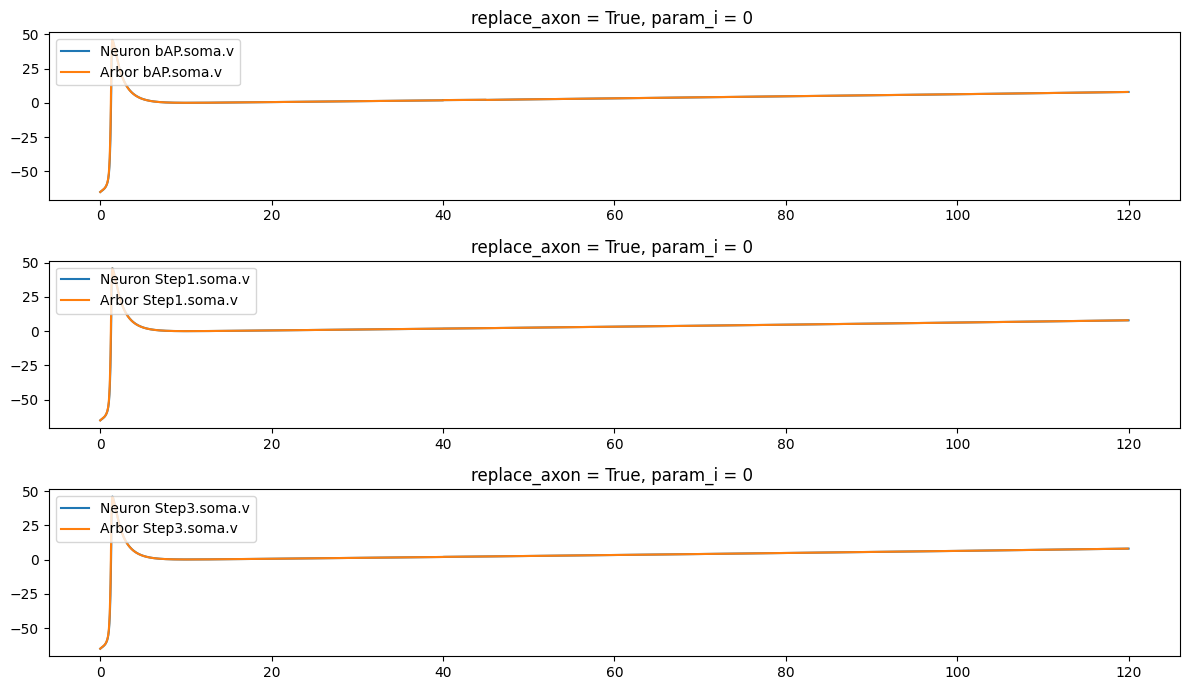

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gK_Pstbar_K_Pst.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
15,True,0,0.323,0.632,0.00673,313,bAP.soma.v,0.000367,1.09e-05
16,True,0,0.323,0.632,0.00673,313,Step1.soma.v,0.000358,7.75e-06
17,True,0,0.323,0.632,0.00673,313,Step3.soma.v,0.000376,1.62e-05


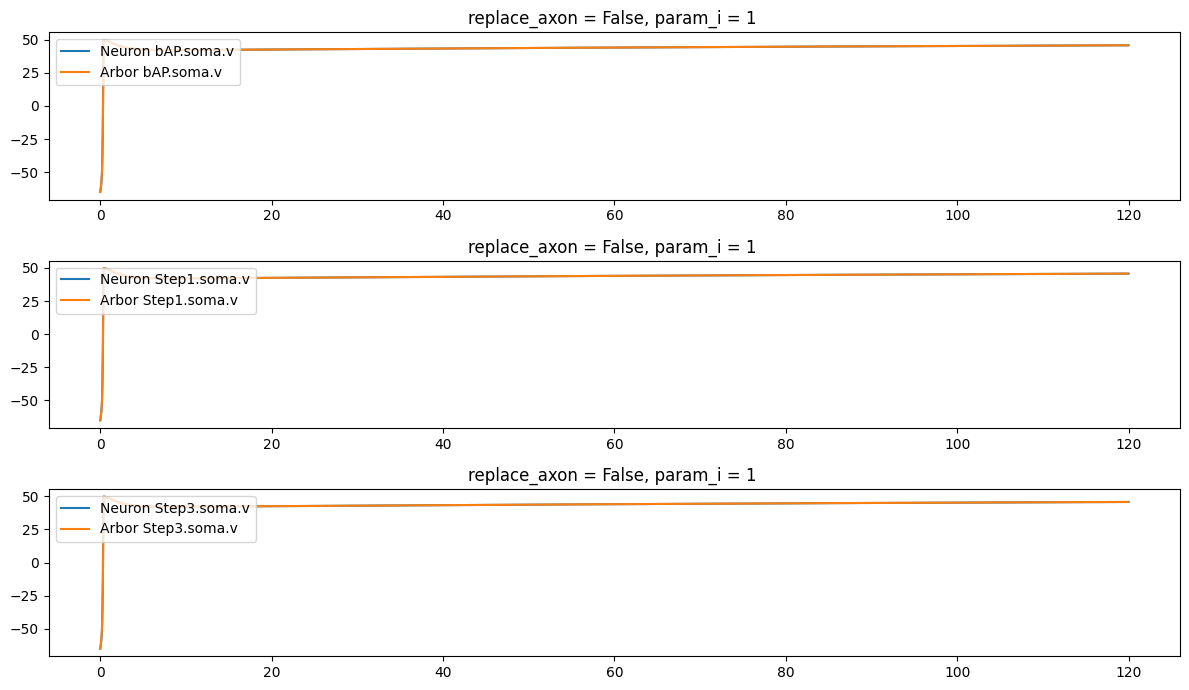

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gK_Pstbar_K_Pst.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
3,False,1,1.96,0.209,0.0475,917,bAP.soma.v,0.0016,8.78e-08
4,False,1,1.96,0.209,0.0475,917,Step1.soma.v,0.00134,1.67e-07
5,False,1,1.96,0.209,0.0475,917,Step3.soma.v,0.00151,2.72e-07


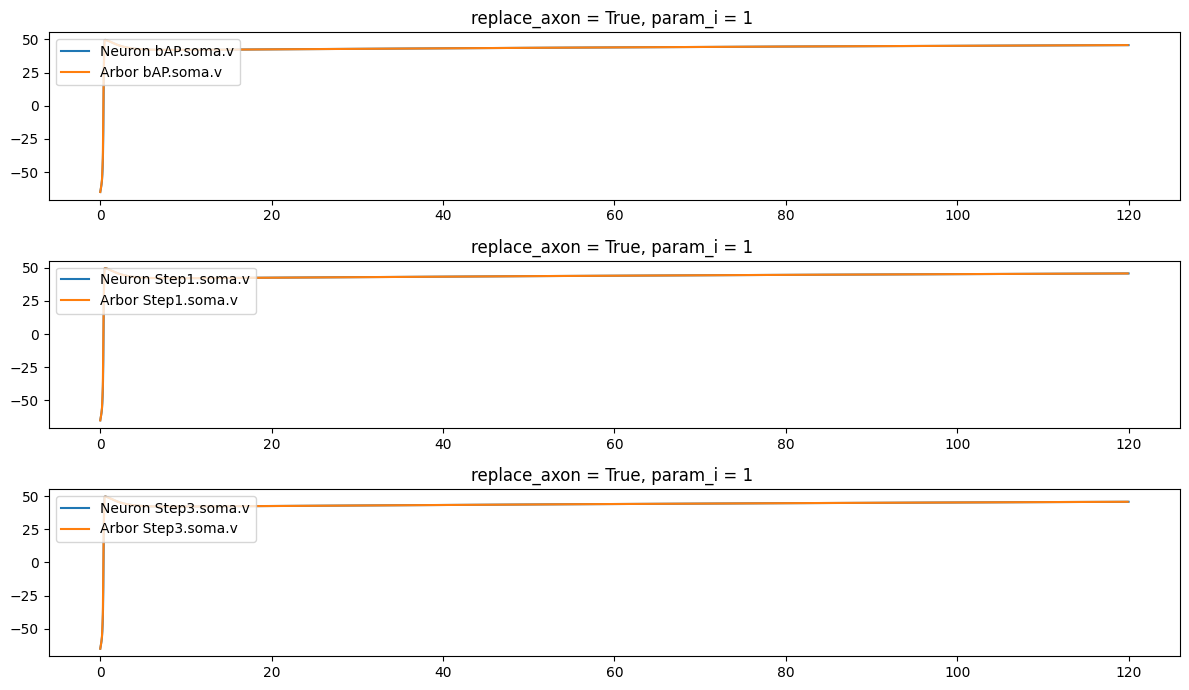

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gK_Pstbar_K_Pst.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
18,True,1,1.96,0.209,0.0475,917,bAP.soma.v,0.00164,1.36e-07
19,True,1,1.96,0.209,0.0475,917,Step1.soma.v,0.000196,6.72e-08
20,True,1,1.96,0.209,0.0475,917,Step3.soma.v,0.000196,8.39e-08


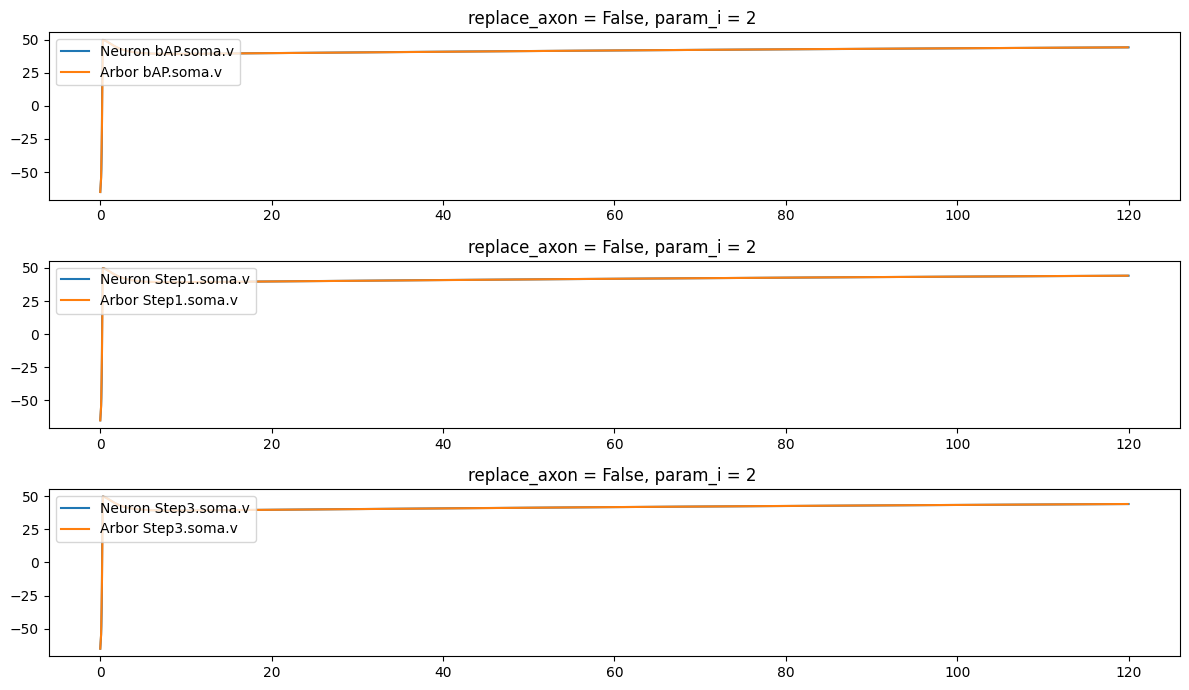

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gK_Pstbar_K_Pst.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
6,False,2,3.87,0.586,0.00533,797,bAP.soma.v,0.00181,4.4e-06
7,False,2,3.87,0.586,0.00533,797,Step1.soma.v,0.00426,0.000825
8,False,2,3.87,0.586,0.00533,797,Step3.soma.v,0.0038,5.94e-05


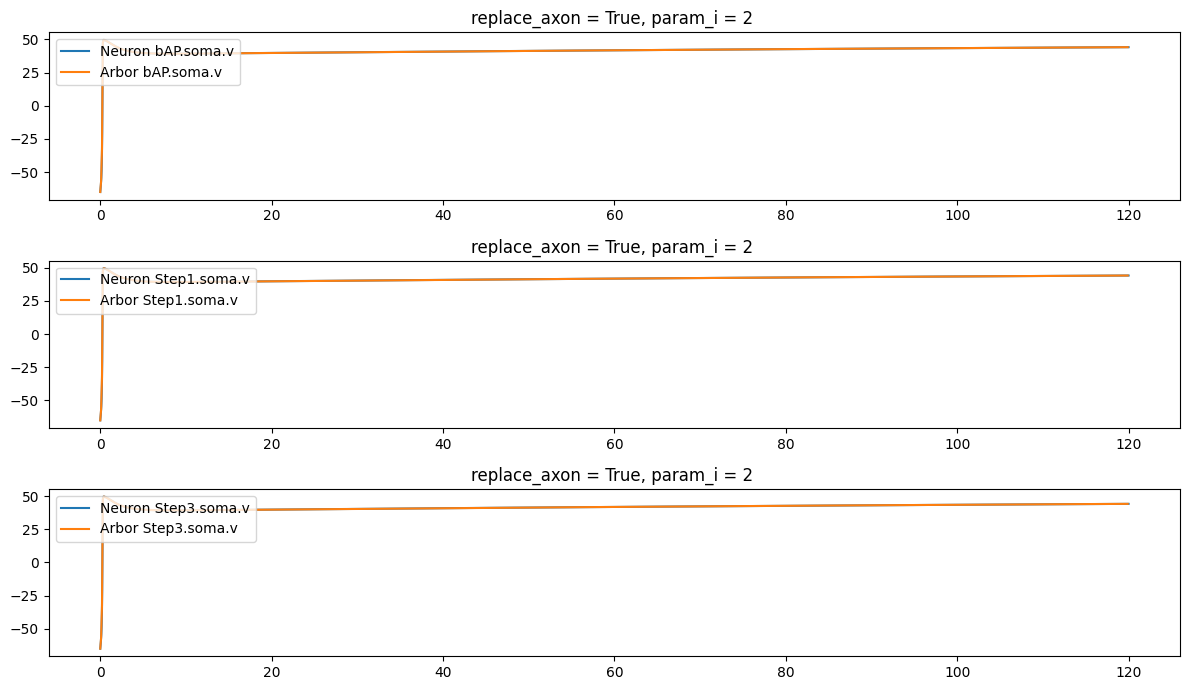

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gK_Pstbar_K_Pst.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
21,True,2,3.87,0.586,0.00533,797,bAP.soma.v,0.000156,1.68e-08
22,True,2,3.87,0.586,0.00533,797,Step1.soma.v,0.000175,2.18e-07
23,True,2,3.87,0.586,0.00533,797,Step3.soma.v,0.000185,9.13e-08


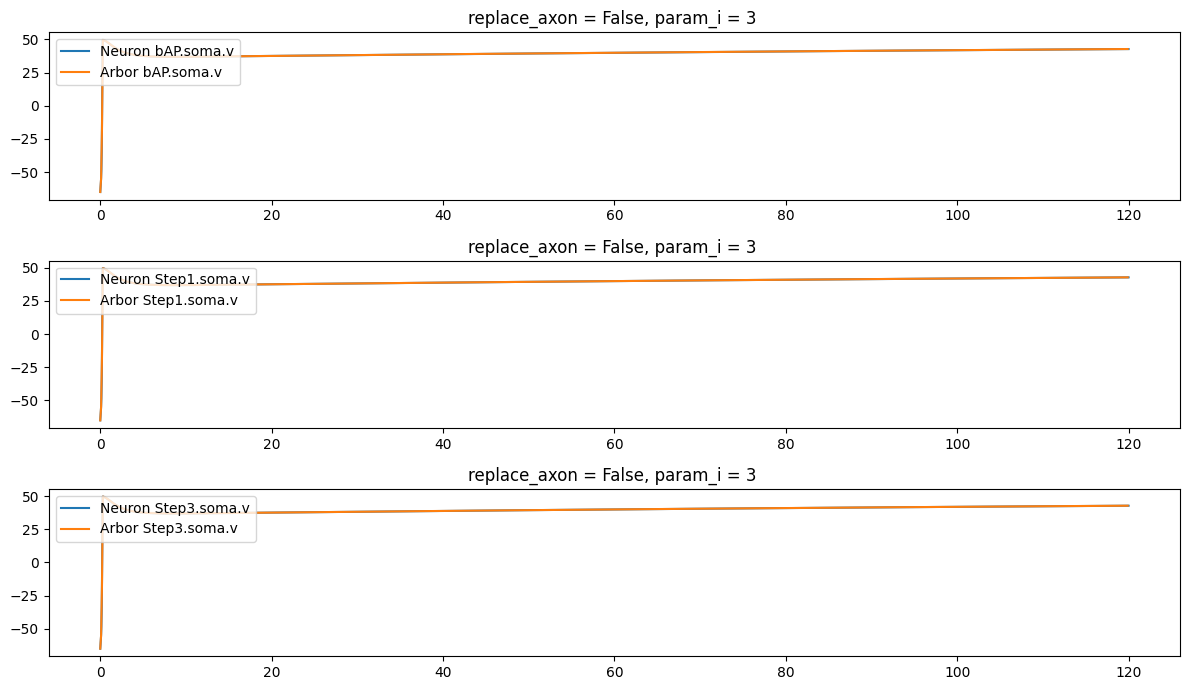

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gK_Pstbar_K_Pst.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
9,False,3,3.72,0.702,0.0181,285,bAP.soma.v,0.00277,1.03e-06
10,False,3,3.72,0.702,0.0181,285,Step1.soma.v,0.000221,6.11e-07
11,False,3,3.72,0.702,0.0181,285,Step3.soma.v,0.000954,5.39e-06


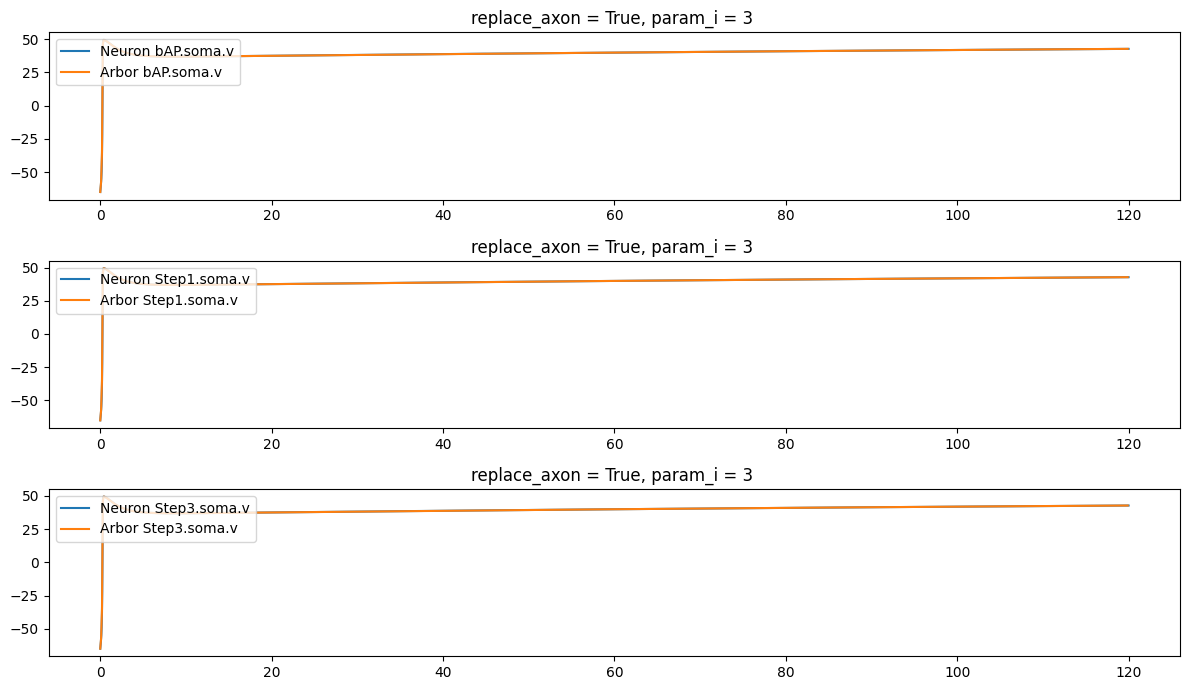

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gK_Pstbar_K_Pst.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
24,True,3,3.72,0.702,0.0181,285,bAP.soma.v,0.0023,4.29e-08
25,True,3,3.72,0.702,0.0181,285,Step1.soma.v,0.00026,1.07e-06
26,True,3,3.72,0.702,0.0181,285,Step3.soma.v,0.000232,1.96e-07


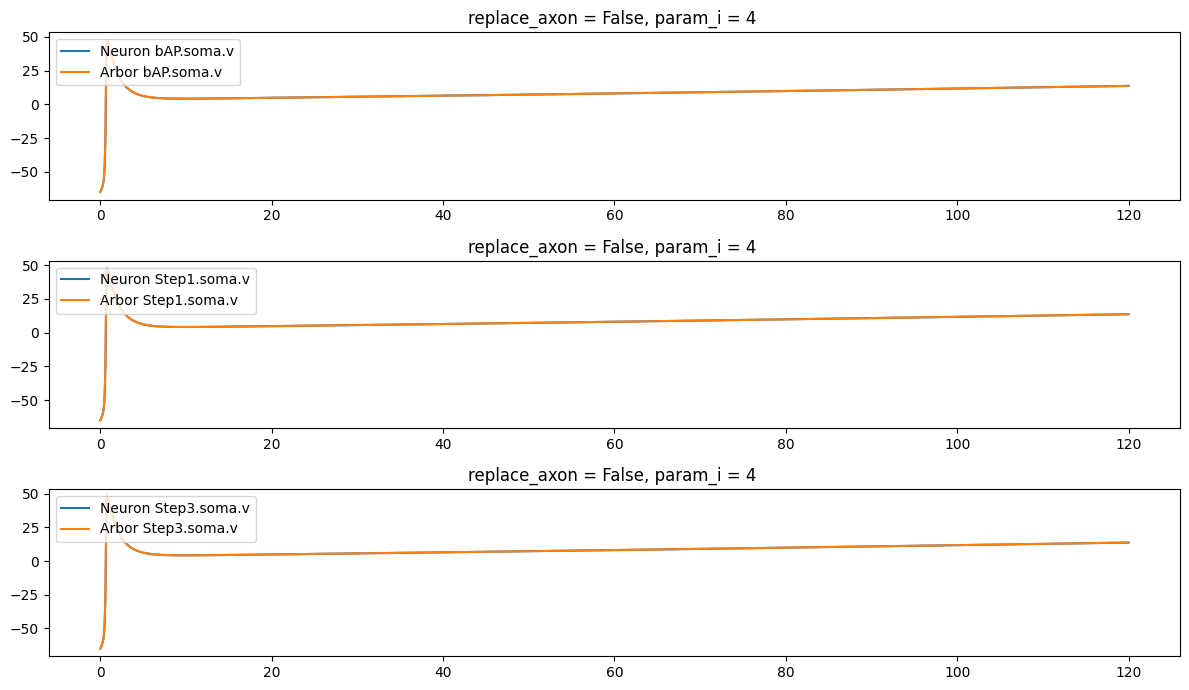

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gK_Pstbar_K_Pst.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
12,False,4,0.62,0.896,0.0479,681,bAP.soma.v,0.000197,0.000339
13,False,4,0.62,0.896,0.0479,681,Step1.soma.v,0.000189,0.00131
14,False,4,0.62,0.896,0.0479,681,Step3.soma.v,0.000187,0.00144


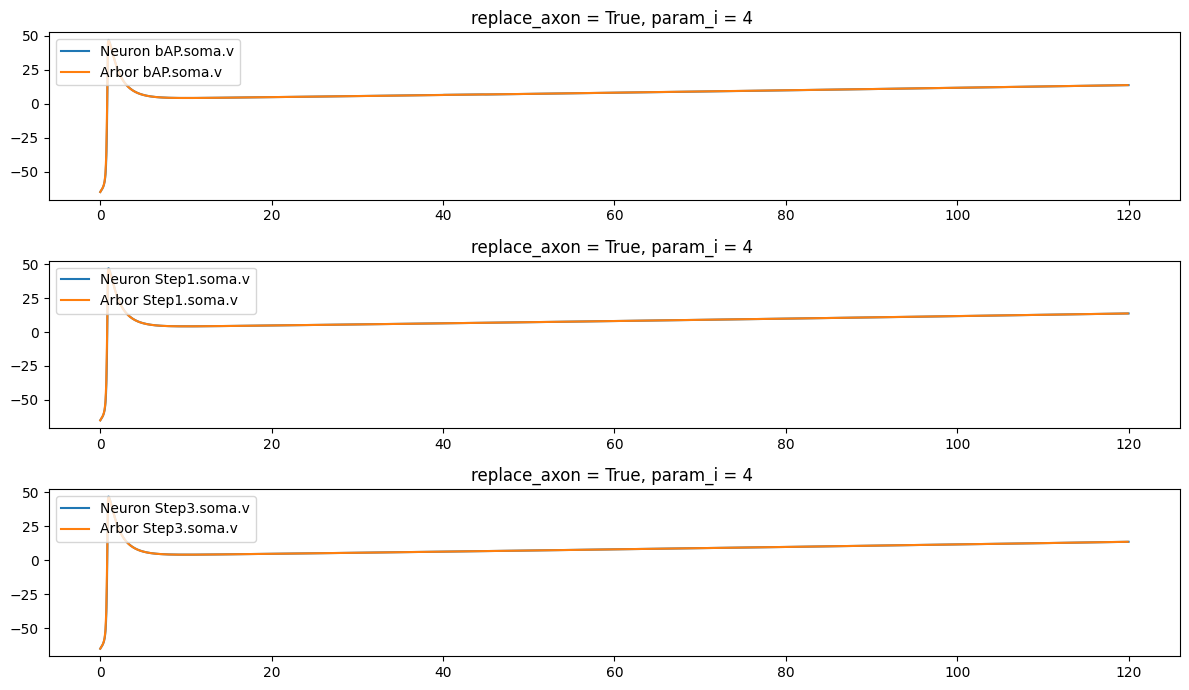

,replace_axon,param_i,gNap_Et2bar_Nap_Et2.somatic,gK_Pstbar_K_Pst.somatic,gamma_CaDynamics_E2.somatic,decay_CaDynamics_E2.somatic,protocol,residual_rel_l1_norm,residual_rel_l1_error
27,True,4,0.62,0.896,0.0479,681,bAP.soma.v,0.0003,4.07e-07
28,True,4,0.62,0.896,0.0479,681,Step1.soma.v,0.00031,3.63e-07
29,True,4,0.62,0.896,0.0479,681,Step3.soma.v,0.000293,1.99e-07


In [24]:
if run_fine_dt:
    for param_i in range(len(params)):
        for do_replace_axon in replace_axon:
            compare_responses(arb_responses_fine_dt,
                              nrn_responses_fine_dt,
                              l1_results_fine_dt,
                              do_replace_axon, param_i)

In [25]:
if run_spike_time_analysis and run_fine_dt:
    spike_results_fine_dt = joint_spike_analysis(arb_responses_fine_dt, nrn_responses_fine_dt, replace_axon, params)
    display(spike_results_fine_dt)

In [26]:
if run_spike_time_analysis and run_fine_dt:
    display(spike_results_fine_dt[['abs_diff Arbor to Neuron',
                                   'rel_abs_diff Arbor to Neuron [%]']].groupby('efel').describe())

The outlier in `time_to_last_spike` is gone now, both visually and quantitatively.

In [27]:
if run_spike_time_analysis and run_fine_dt:
    display(spike_results_fine_dt[ [el[spike_results_fine_dt.index.names.index('efel')] == 'time_to_last_spike'
                                    for el in spike_results_fine_dt.index] ].sort_values(
                                    by='abs_diff Arbor to Neuron', ascending=False).head(5))

Furthermore, the mean deviation between Arbor and Neuron for eFEL spike times is significantly reduced.

In [28]:
if run_spike_time_analysis and run_fine_dt:
    display((spike_results_fine_dt[['abs_diff Arbor to Neuron']].groupby('efel').mean()/
             spike_results[['abs_diff Arbor to Neuron']].groupby('efel').mean()).rename(
                 columns={'abs_diff Arbor to Neuron': 
                         'ratio of mean abs_diff Arbor to Neuron for fine dt vs. default dt'}))
